In [20]:
import os
from pathlib import Path

import numpy as np
import mplhep as hep
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from collections import OrderedDict

from functions import EMA, load_data, sample_data
from plotting_functions import histogram, scatter, get_nhit, get_espec, emd

mpl.style.use('classic')

CUDA = True
device = torch.device("cuda" if CUDA else "cpu")

In [11]:
abs_path = '/media/marcelomd/HDD2/UFRGS/TCC/Dados'
data_dir_path = abs_path + '/datasets/SB_Refinement'

In [12]:
from score_models import ChebyScoreKAN as ScoreNetworkEnergy
from score_models import SquirelsScoreNetworkConv as ScoreNetworkConv

## ----------------------------------------------------------------------------------------------------
## Energy
## ----------------------------------------------------------------------------------------------------
modelEnergy_type = "Chebyshev"
i1 = 256
i2 = 128
energy_encoder_layers = [i1,i1]
pos_dim = i2
decoder_layers = [i1,i1]
modelEnergy_version = f"{energy_encoder_layers[0]}_{pos_dim}_{decoder_layers[0]}"
## ----------------------------------------------------------------------------------------------------
## Conv
## ----------------------------------------------------------------------------------------------------
modelConv_type = "SQuIRELS"
i3 = 256
conv_encoder_layers = [i3,i3]
temb_dim = 128
conv_dof = 32
modelConv_version = f"{conv_encoder_layers[0]}_{temb_dim}_{conv_dof}"
## ----------------------------------------------------------------------------------------------------
## Paths
## ----------------------------------------------------------------------------------------------------
# models_dir_path = f'{abs_path}/models/'
# plots_dir_path = f'{abs_path}/plots/'

models_energy_dir_path = f'{abs_path}/models/Energy/{modelEnergy_type}/{modelEnergy_version}/'#(original)
models_conv_dir_path = f'{abs_path}/models/Conv/{modelConv_type}/{modelConv_version}/'#(original)

full_modelEnergy_name = f"{modelEnergy_type}_{modelEnergy_version}"
full_modelConv_name = f"{modelConv_type}_{modelConv_version}"

plots_dir_path = f'{abs_path}/plots/{full_modelEnergy_name}_{full_modelConv_name}/'#(original)
metrics_dir_path = f'{abs_path}/metrics/{full_modelEnergy_name}_{full_modelConv_name}/'#(original)

record_metrics = True
generate_plots = True
full_model_metrics = False

energy_iter_list = range(1,20) #[19]
conv_iter_list = [14]*19#range(1,20) #[19]


In [13]:
line_style = {
    'Geant4':'dotted',
    'GFlash':'-',
    full_modelEnergy_name:'-',
    full_modelConv_name:'-',
}

colors = {
    'Geant4':'black',
    'GFlash':'red',
    full_modelEnergy_name:'#2ca25f',
    full_modelConv_name:'#7570b3',
}

rc('text', usetex=True)
rc('font', family='serif')
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

mpl.rcParams.update({'font.size': 19})
mpl.rcParams.update({'figure.titlesize': 11})
mpl.rcParams.update({'xtick.labelsize': 18})
mpl.rcParams.update({'ytick.labelsize': 18})
mpl.rcParams.update({'axes.labelsize': 18})
mpl.rcParams.update({'legend.frameon': False})
mpl.rcParams.update({'lines.linewidth': 2})

hep.style.use("CMS")

mpl.rcParams['text.usetex'] = False
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [14]:
file_path_gflash = data_dir_path + '/run_GFlash01_100k_10_100GeV_eval_full.npy'
file_path_g4 = data_dir_path + '/run_Geant_100k_10_100GeV_eval_full.npy'

data = load_data(file_path_gflash=file_path_gflash, file_path_g4=file_path_g4, normalize_energy=True)

In [15]:
energy_voxel_g4 = data['energy_voxel_g4']
energy_voxel_gflash = data['energy_voxel_gflash']
energy_gflash = data['energy_gflash']
energy_g4 = data['energy_g4']
energy_particle_gflash = data['energy_particle_gflash']
energy_particle_g4 = data['energy_particle_g4']

batch_size = 10000

npar = int(energy_voxel_g4.shape[0])

X_init = energy_voxel_gflash
Y_init = np.concatenate((energy_gflash, energy_g4, energy_particle_gflash), 1)
init_sample = torch.tensor(X_init).view(X_init.shape[0], 1, 10, 10)
init_lable = torch.tensor(Y_init)
scaling_factor = 7
#init_sample = (init_sample - init_sample.mean()) / init_sample.std() * scaling_factor
init_ds = TensorDataset(init_sample, init_lable)
init_dl = DataLoader(init_ds, batch_size=batch_size, shuffle=False)
#init_dl = repeater(init_dl)
# print(init_sample.shape)

X_final = energy_voxel_g4
Y_final = np.concatenate((energy_g4, energy_gflash, energy_particle_g4), 1)
scaling_factor = 7.
final_sample = torch.tensor(X_final).view(X_final.shape[0], 1, 10, 10)
final_label = torch.tensor(Y_final)
#final_sample = (final_sample - final_sample.mean()) / final_sample.std() * scaling_factor
final_ds = TensorDataset(final_sample, final_label)
final_dl = DataLoader(final_ds, batch_size=batch_size, shuffle=False)
#final_dl = repeater(final_dl)

#mean_final = torch.tensor(0.)
#var_final = torch.tensor(1.*10**3) #infty like

mean_final = torch.zeros(1, 10, 10).to(device)
var_final = 1.*torch.ones(1, 10, 10).to(device)

# print(final_sample.shape)
# print(mean_final.shape)
# print(var_final.shape)

dls = {'f': init_dl, 'b': final_dl}

d = init_sample[0].shape  # shape of object to diffuse
dy = init_lable[0].shape  # shape of object to diffuse
de = [1]  # shape of object to diffuse

lr = 1e-5

num_steps_voxel = 20
gamma_max_voxel = 0.001
gamma_min_voxel = 0.001

n = num_steps_voxel//2
gamma_half_voxel = np.linspace(gamma_min_voxel, gamma_max_voxel, n)
gammas_voxel = np.concatenate([gamma_half_voxel, np.flip(gamma_half_voxel)])
gammas_voxel = torch.tensor(gammas_voxel).to(device)
T_voxel = torch.sum(gammas_voxel)

# print(gammas_voxel)

num_steps_energy = 20
gamma_max_energy = 0.001
gamma_min_energy = 0.001

n = num_steps_energy//2
gamma_half_energy = np.linspace(gamma_min_energy, gamma_max_energy, n)
gammas_energy = np.concatenate([gamma_half_energy, np.flip(gamma_half_energy)])
gammas_energy = torch.tensor(gammas_energy).to(device)
T_energy = torch.sum(gammas_energy)

# print(gammas_energy)

In [16]:
## ----------------------------------------------------------------------------------------------------
## Energy
## ----------------------------------------------------------------------------------------------------
modelEnergy_f = ScoreNetworkEnergy(encoder_layers=energy_encoder_layers,
                                   pos_dim=pos_dim,
                                   decoder_layers=decoder_layers,
                                   n_cond = 1).to(device)

modelEnergy_b = ScoreNetworkEnergy(encoder_layers=energy_encoder_layers,
                                   pos_dim=pos_dim,
                                   decoder_layers=decoder_layers,
                                   n_cond = 1).to(device)

modelEnergy_name = str(modelEnergy_f.__class__)[21:-2]



## ----------------------------------------------------------------------------------------------------
## Conv
## ----------------------------------------------------------------------------------------------------
modelConv_f = ScoreNetworkConv(encoder_layers=conv_encoder_layers,
                               temb_dim=temb_dim,
                               conv_dof=conv_dof,
                               n_cond = init_lable.size(1)).to(device)

modelConv_b = ScoreNetworkConv(encoder_layers=conv_encoder_layers,
                               temb_dim=temb_dim,
                               conv_dof=conv_dof,
                               n_cond = init_lable.size(1)).to(device)

modelConv_name = str(modelConv_f.__class__)[21:-2]


In [17]:
if record_metrics:
  Path(metrics_dir_path).mkdir(parents=True, exist_ok=True)

if generate_plots:
  Path(plots_dir_path).mkdir(parents=True, exist_ok=True)

  cutOff = 0.0

  triangle=True

  y_lim_ratio_l = {'esum': [0.9, 1.1],
                  'esumfrac': [0.0, 2.0],
                  'emax': [0.0, 2.0],
                  'nhit': [0.0, 2.0],
                  'espec': [0.0, 2.0],
                  'ex': [0.0, 2.0],
                  }

  binning_l = {'esum': np.linspace(5,105,50),
              'esumfrac': np.linspace(0.97,1.01,50),
              'emax': np.linspace(0, 27,50),
              'nhit': np.linspace(0, 100,101),
              'espec': np.logspace(-4, 1.5, 100),
              'ex': np.linspace(0, 10,11),
              }

  y_range_l = {'esum': None,
              'esumfrac': None,
              'emax': None,
              'nhit': None,
              'espec': [1e-6, 1e3],
              'ex': [8e-3, 5e2],
              }

Iteration: 0


/home/marcelomd/miniconda3/envs/sb_ref/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Geant4
EMD distance is: 0.09410093090677782+-0.03967029771564955
GFlash
EMD distance is: 0.29970942608365175+-0.07576789163062893
Chebyshev_256_128_256
EMD distance is: 0.09554622858242036+-0.035687914604298945
Total Energy Sum [GeV], 10-100 GeV , Chebyshev_256_128_256:   & 0.094$\pm$0.040 & 0.300$\pm$0.076 & 0.096$\pm$0.036
Total Energy Sum [GeV], 10-100 GeV , Chebyshev_256_128_256:   & 0.09(4) & 0.30(8) & 0.10(4)
Geant4
EMD distance is: 2.0488777055393224e-05+-5.005876163327345e-06
GFlash
EMD distance is: 0.005282081194861518+-1.1715383226416274e-05
Chebyshev_256_128_256
EMD distance is: 0.000693073649577015+-7.805877084484723e-06
$E_{shower}/E_{particle}$, 10-100 GeV , Chebyshev_256_128_256:   & 0.000020$\pm$0.000005 & 0.005282$\pm$0.000012 & 0.000693$\pm$0.000008
$E_{shower}/E_{particle}$, 10-100 GeV , Chebyshev_256_128_256:   & 0.000020(5) & 0.00528(1) & 0.000693(8)
{'Esum1D_Geant4': 0.08914772639806846, 'Esum1D_GFlash': 0.2705480854284276, 'Esum1D_Chebyshev_256_128_256': 0.095606

/media/marcelomd/HDD2/UFRGS/TCC/Dados/repos/KADSB-Refinement/plotting_functions.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(9, 7))


Geant4
EMD distance is: 0.0868676663357266+-0.034810773313849595
GFlash
EMD distance is: 0.28340207691352637+-0.07189030894552441
Chebyshev_256_128_256
EMD distance is: 0.09321129178748427+-0.029839440441908695
Total Energy Sum [GeV], 10-100 GeV , Chebyshev_256_128_256:   & 0.087$\pm$0.035 & 0.283$\pm$0.072 & 0.093$\pm$0.030
Total Energy Sum [GeV], 10-100 GeV , Chebyshev_256_128_256:   & 0.09(3) & 0.28(7) & 0.09(3)
Geant4
EMD distance is: 2.0175427828770833e-05+-5.054495179662637e-06
GFlash
EMD distance is: 0.00528146257758914+-1.1565409994711126e-05
Chebyshev_256_128_256
EMD distance is: 0.0006746688058516948+-7.858954708481235e-06
$E_{shower}/E_{particle}$, 10-100 GeV , Chebyshev_256_128_256:   & 0.000020$\pm$0.000005 & 0.005281$\pm$0.000012 & 0.000675$\pm$0.000008
$E_{shower}/E_{particle}$, 10-100 GeV , Chebyshev_256_128_256:   & 0.000020(5) & 0.00528(1) & 0.000675(8)
{'Esum1D_Geant4': 0.08349932224252526, 'Esum1D_GFlash': 0.28139902592658683, 'Esum1D_Chebyshev_256_128_256': 0.10080

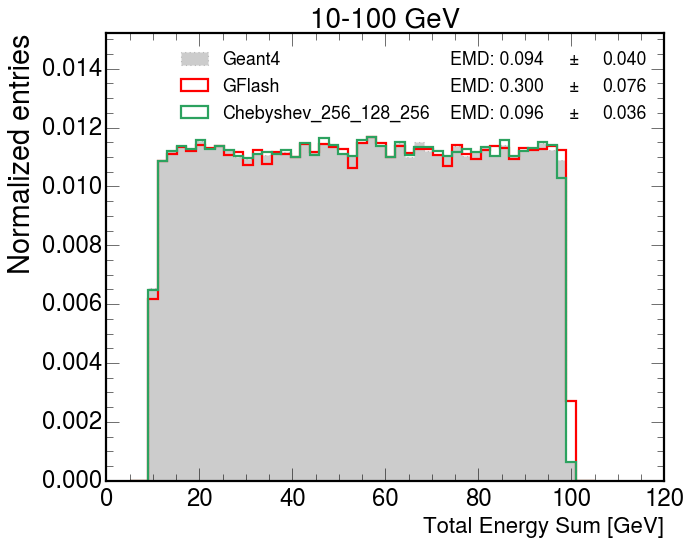

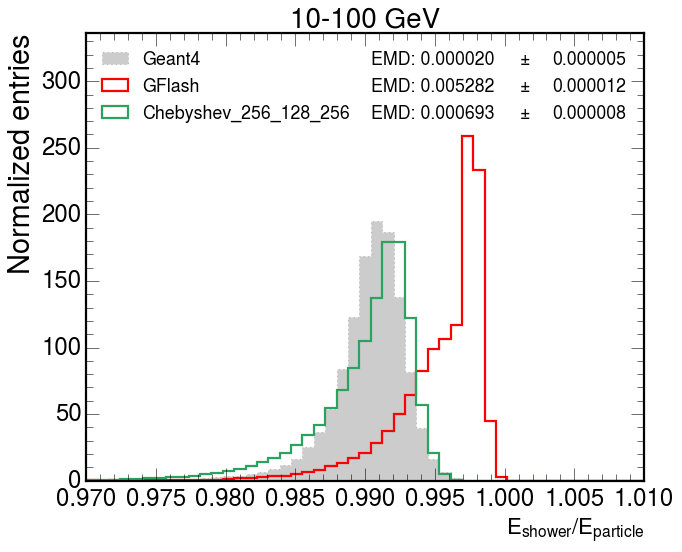

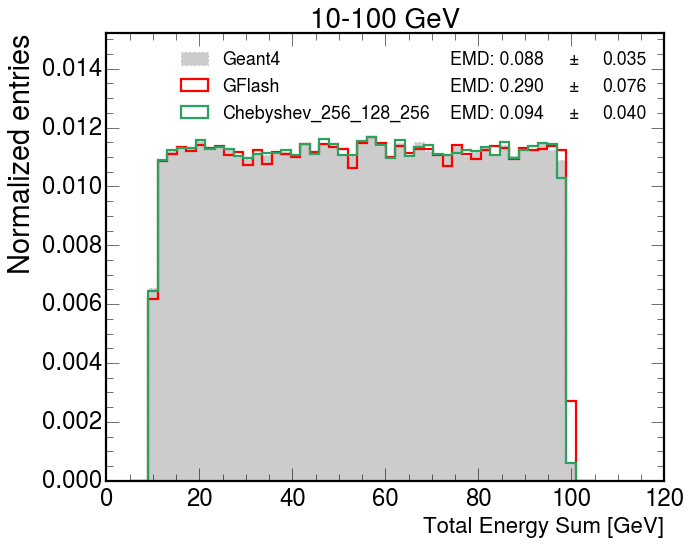

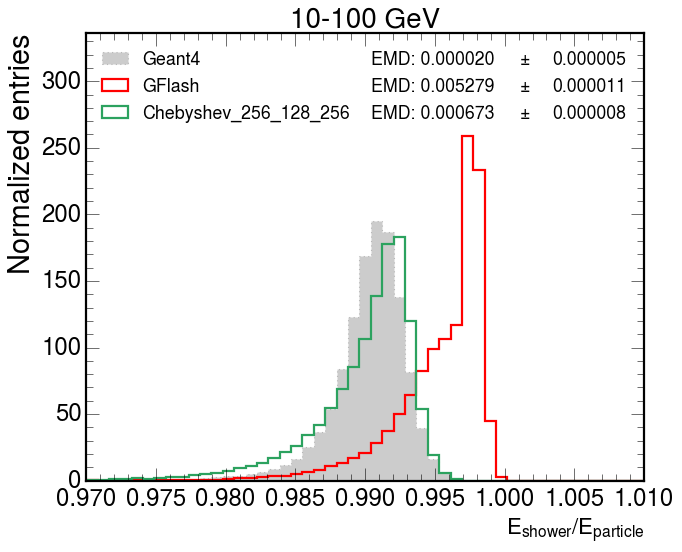

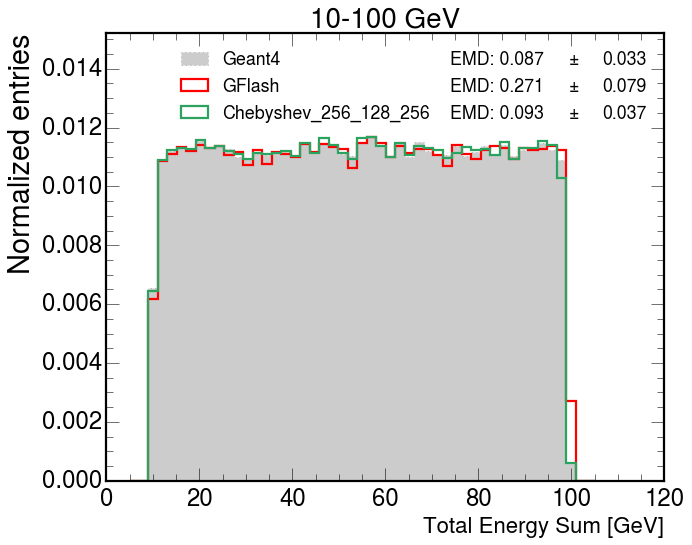

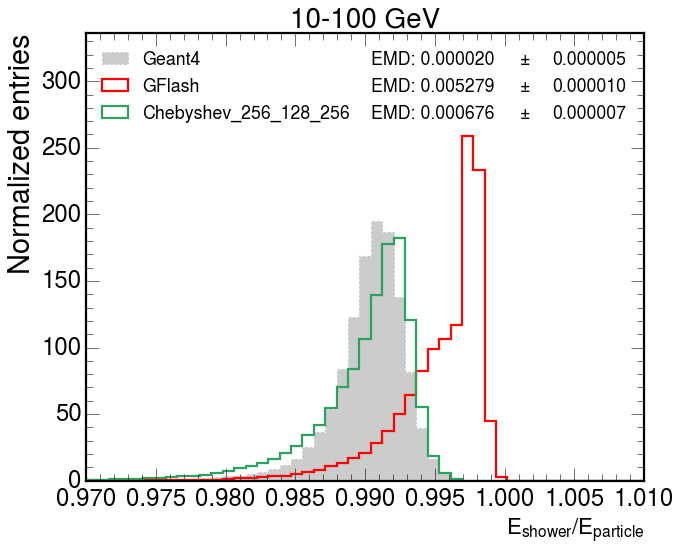

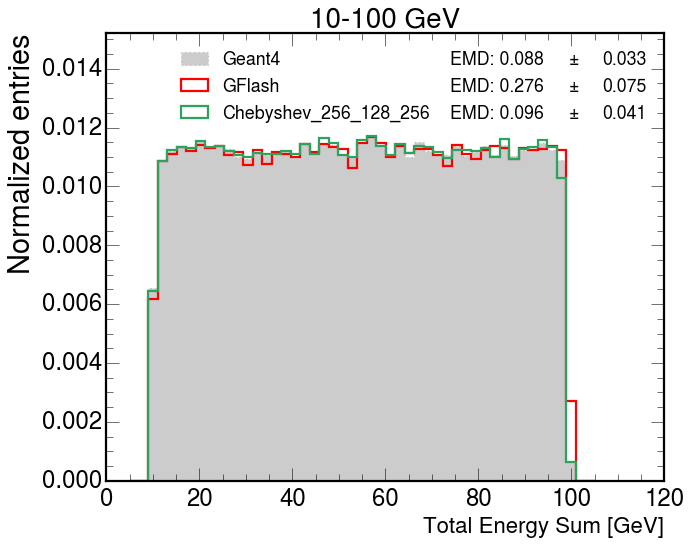

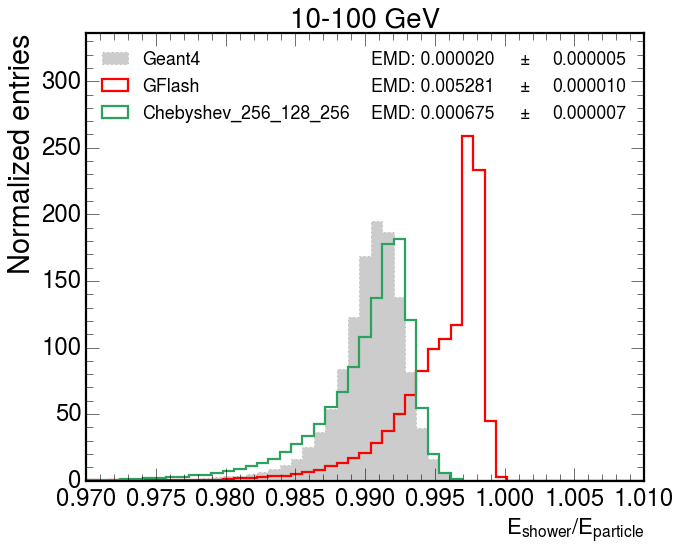

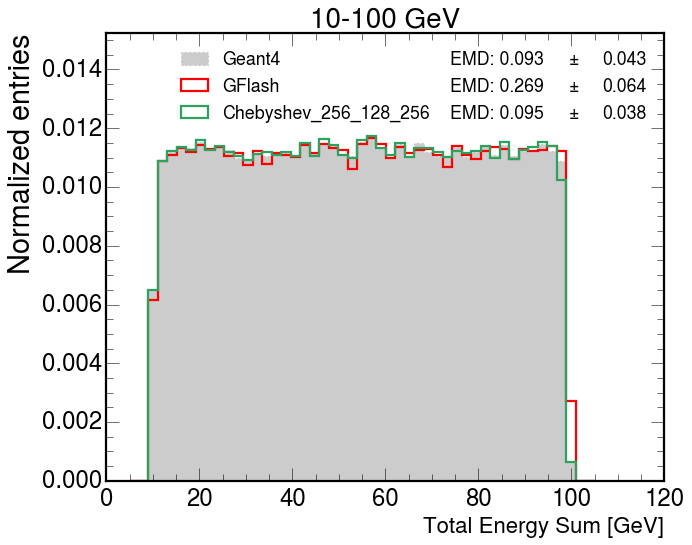

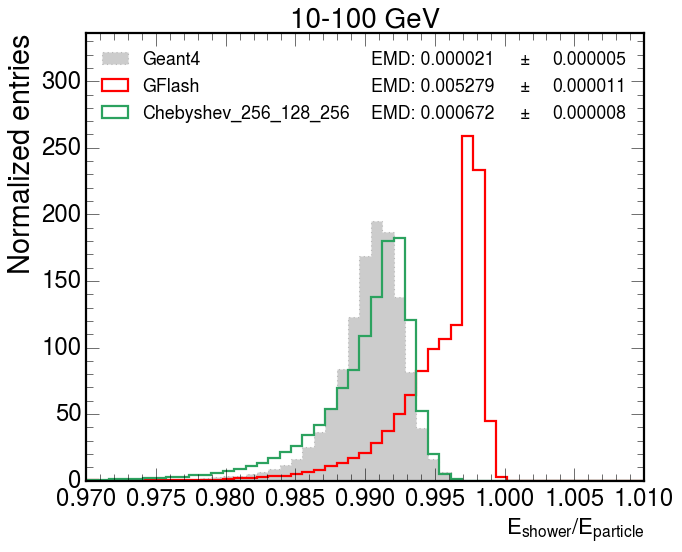

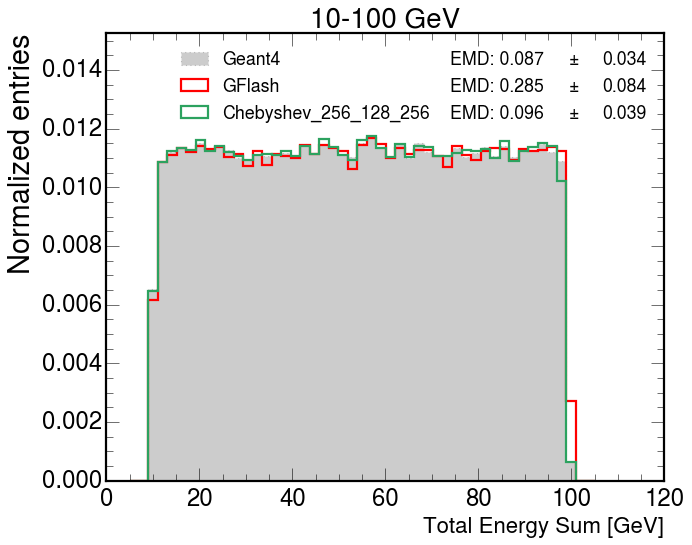

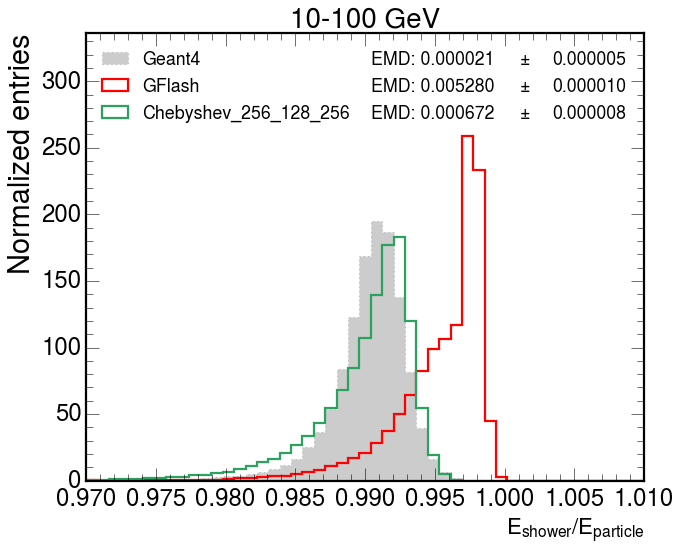

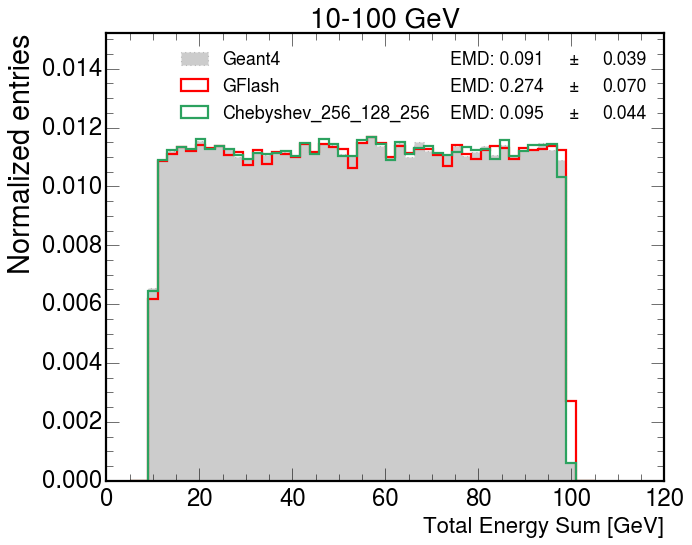

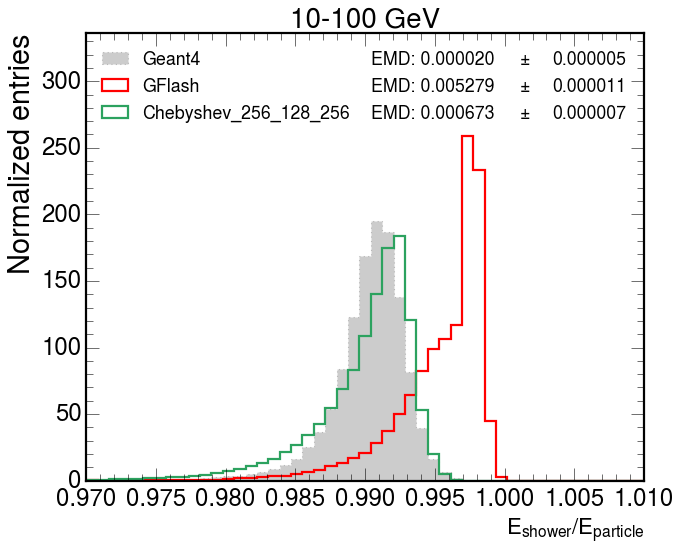

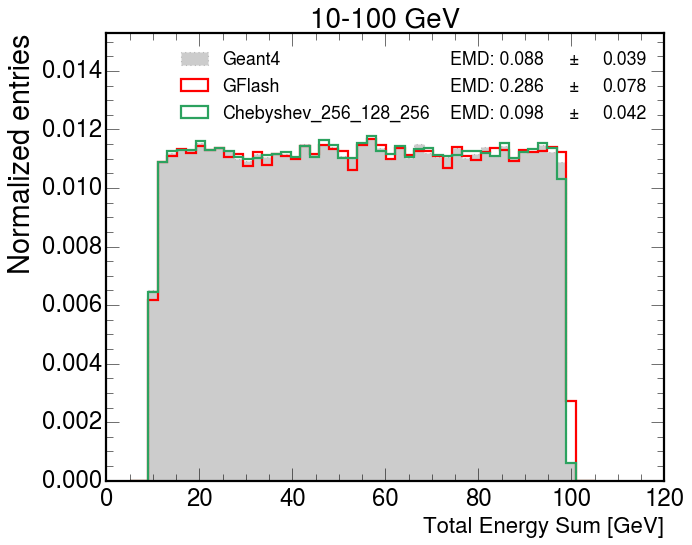

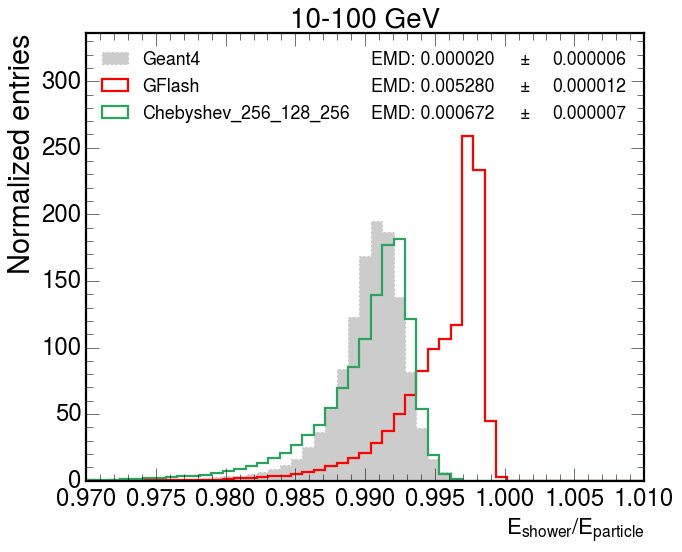

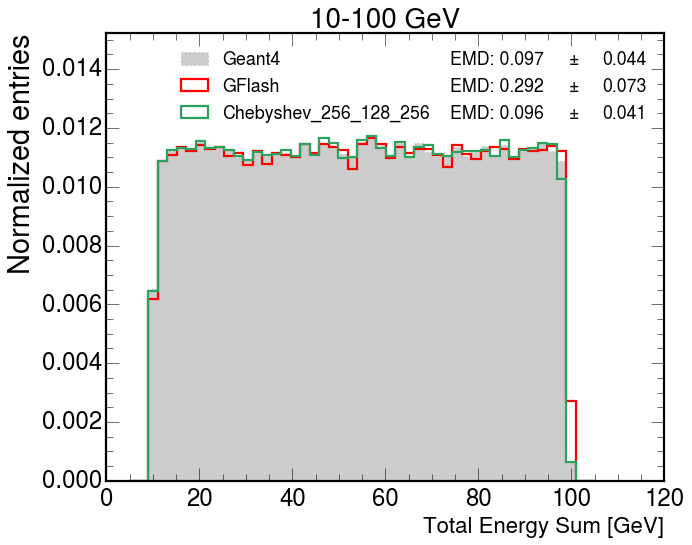

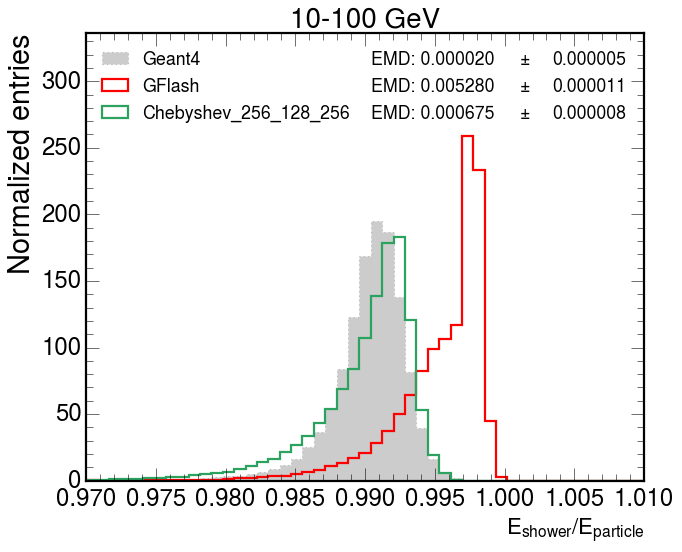

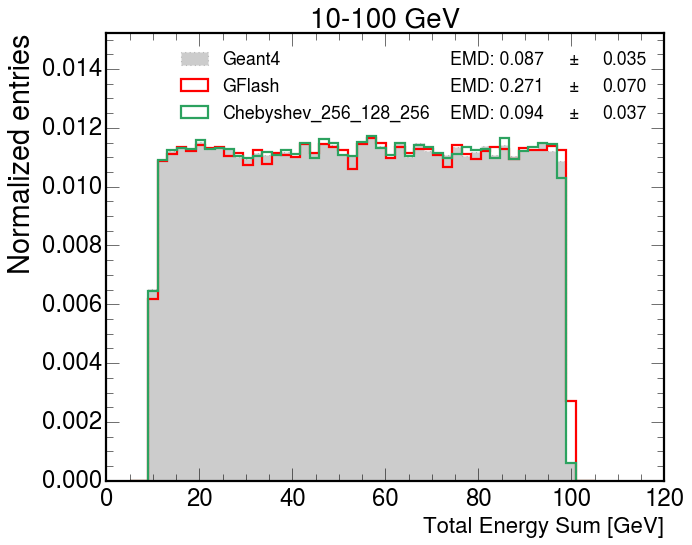

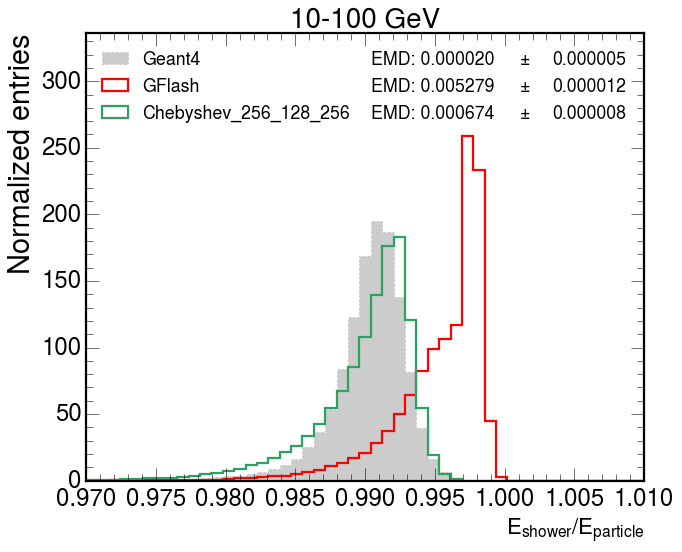

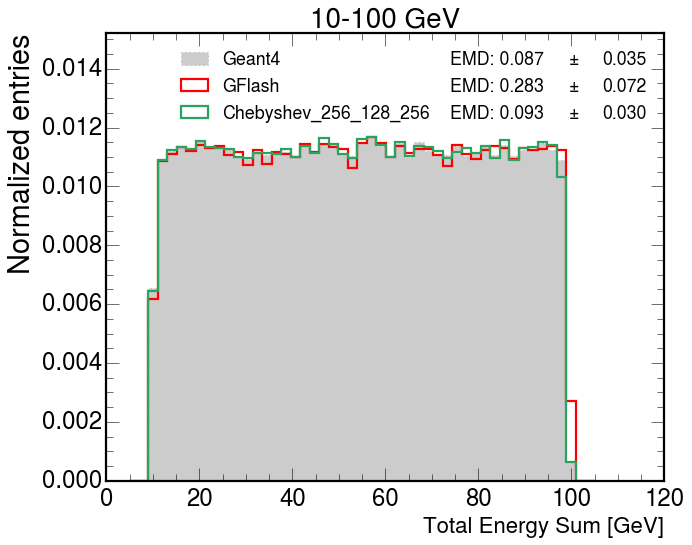

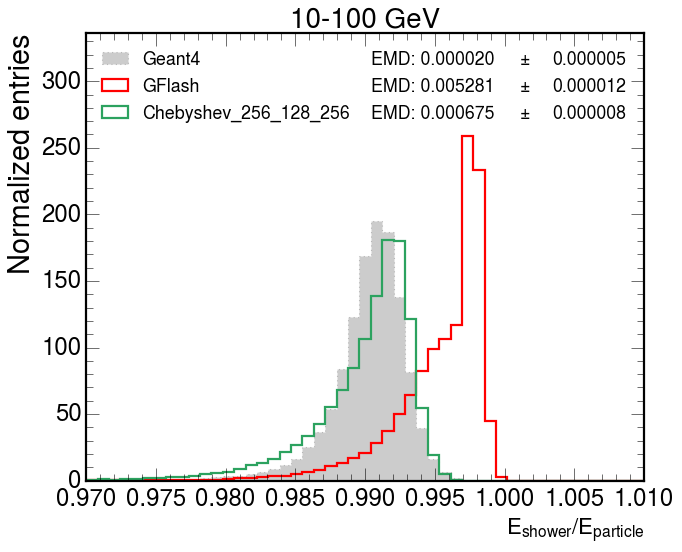

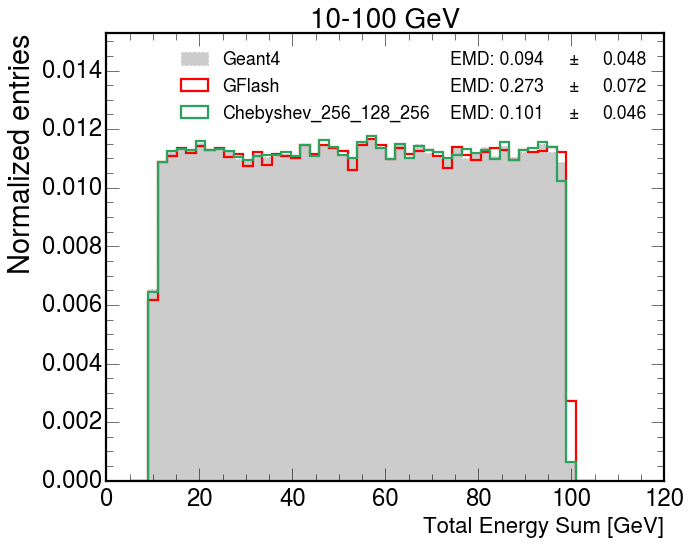

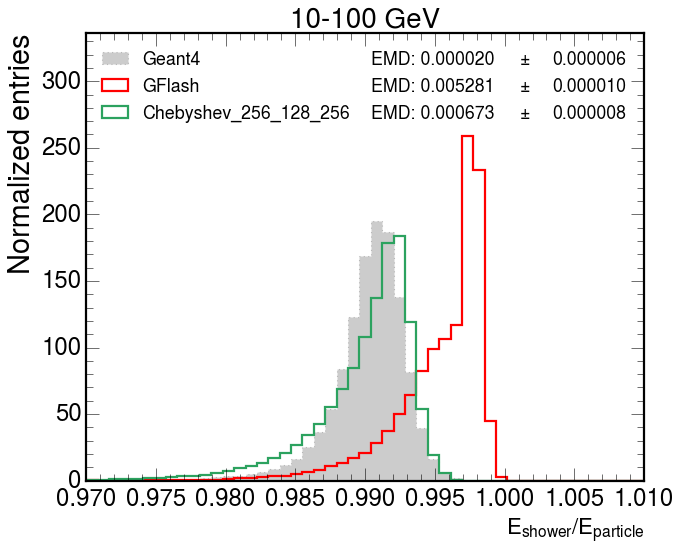

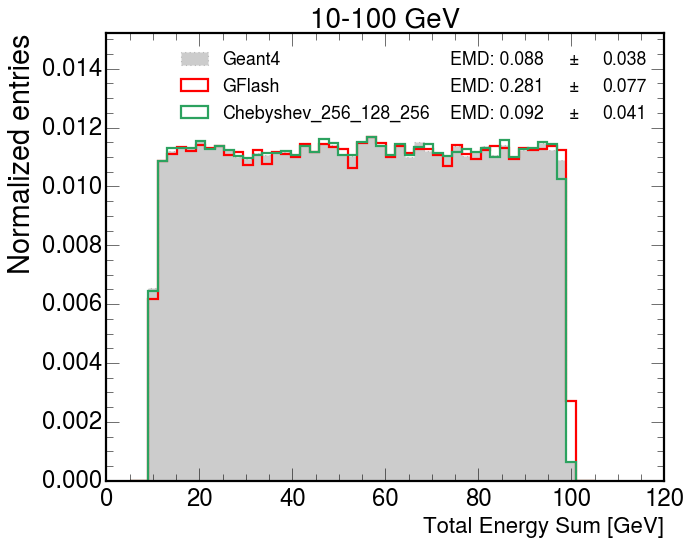

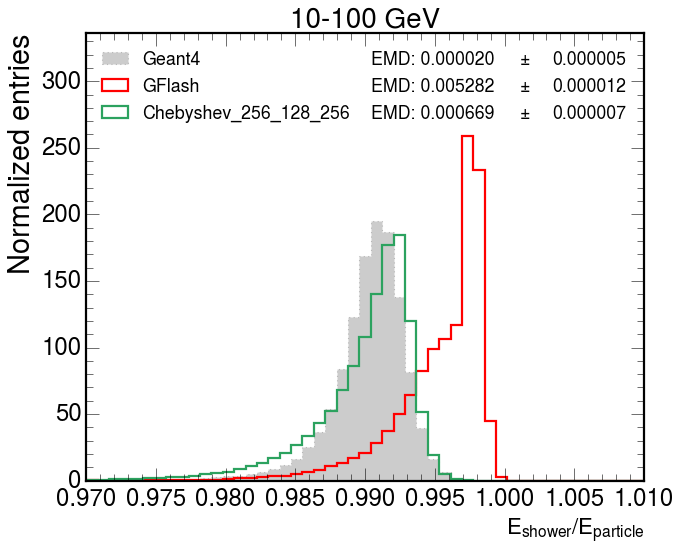

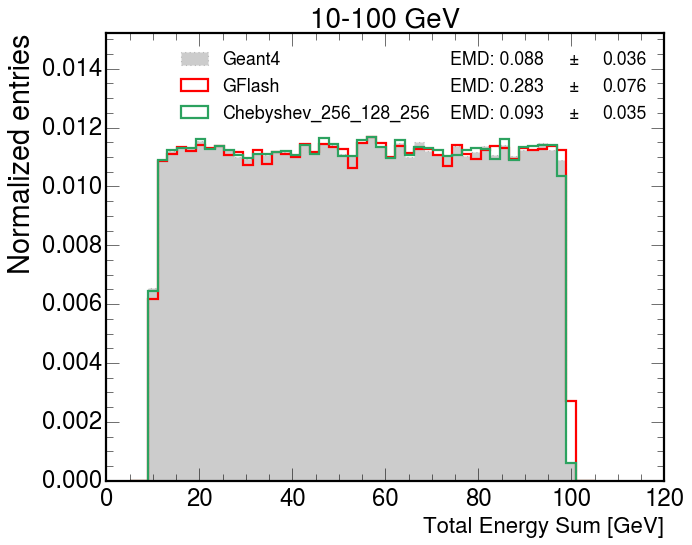

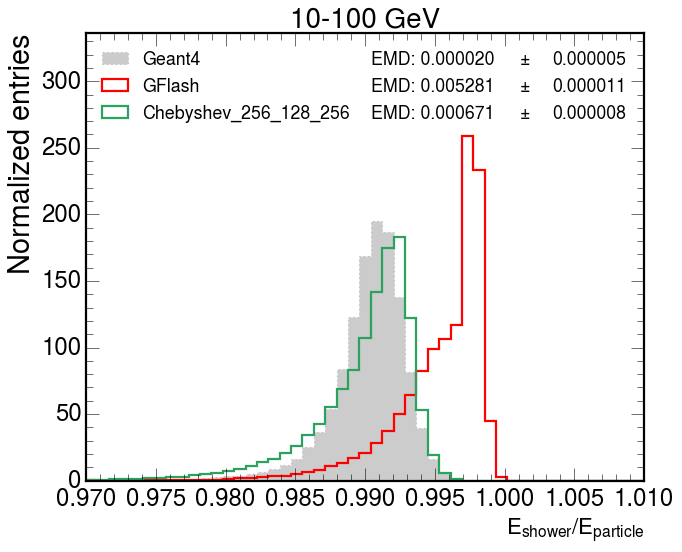

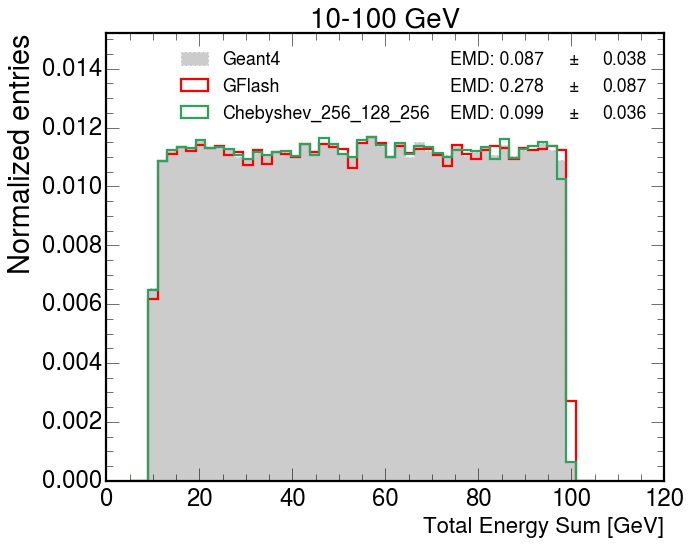

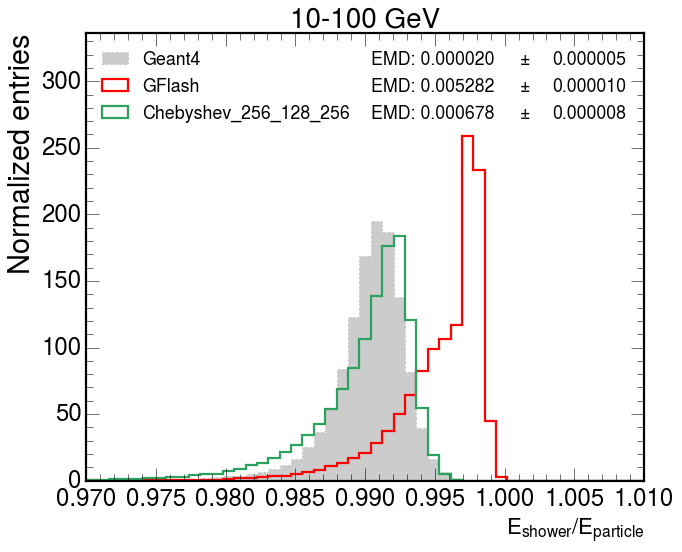

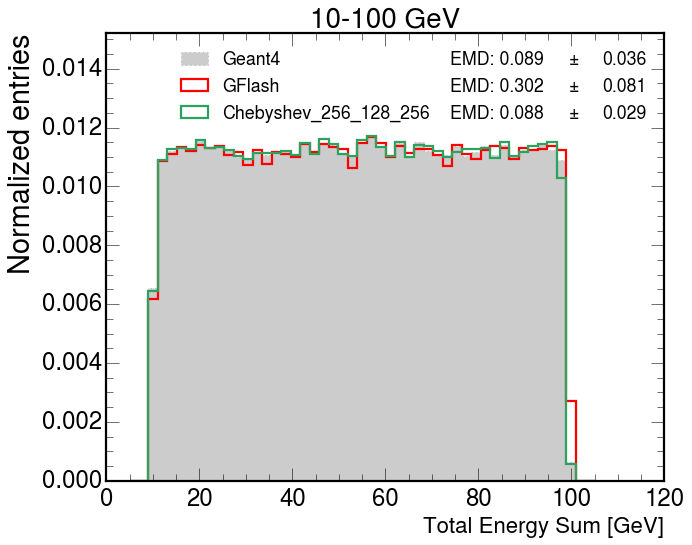

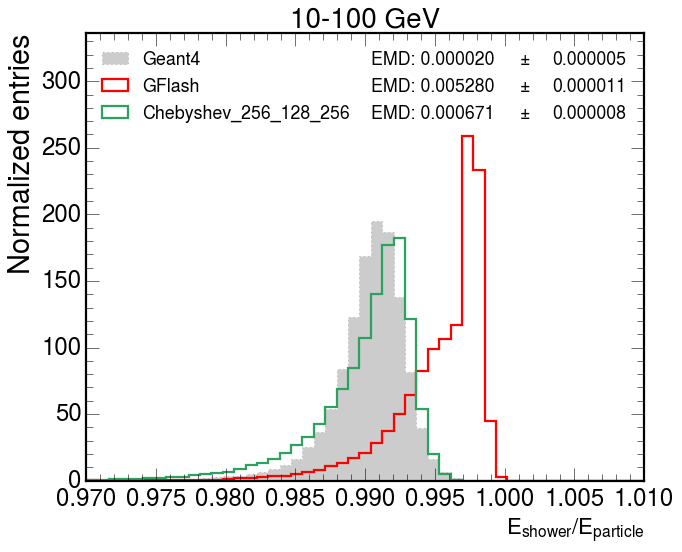

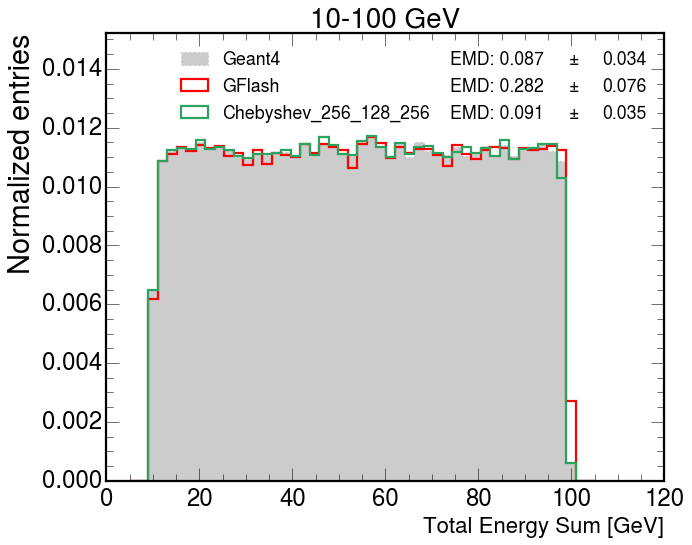

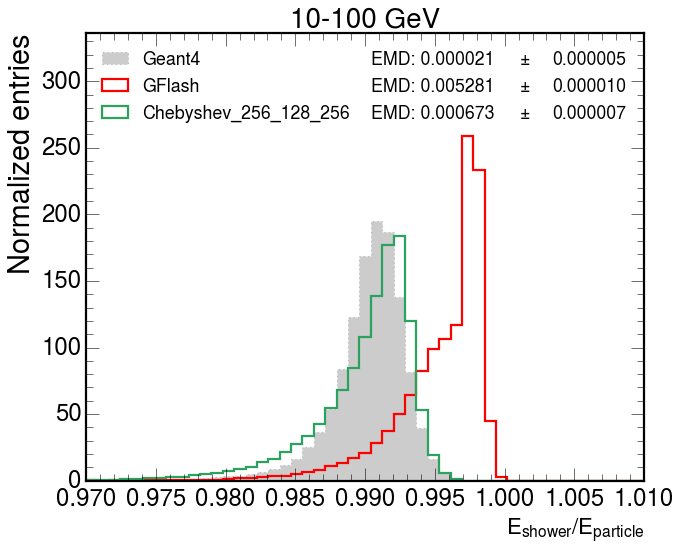

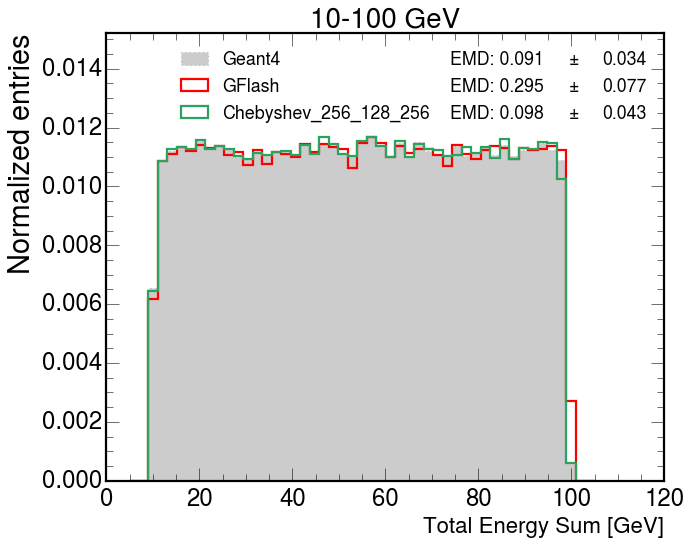

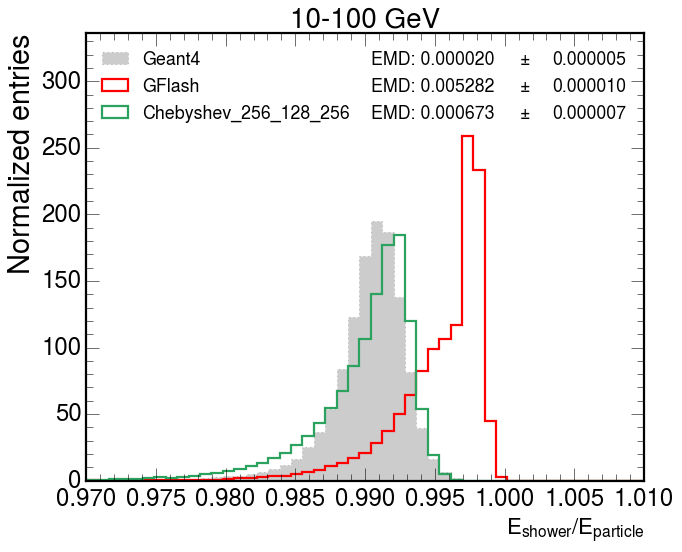

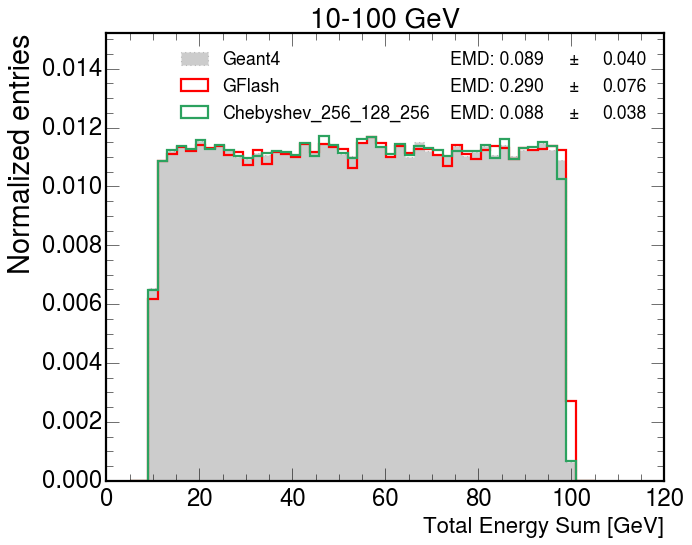

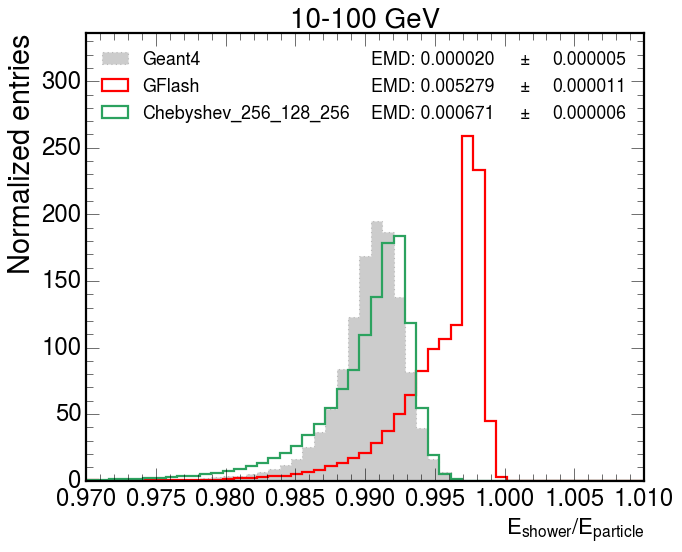

In [18]:
## decay=1.0: No change on update
## decay=0.0: No memory of previous updates, memory is euqal to last update
## decay=0.9: New value 9 parts previous updates, 1 part current update
## decay=0.95: New value 49 parts previous updates, 1 part current update
metrics = pd.DataFrame()
errors = pd.DataFrame()

for i in range(len(energy_iter_list)):

  print(f"Iteration: {i}")

  modelEnergy_f = torch.nn.DataParallel(modelEnergy_f)
  modelEnergy_b = torch.nn.DataParallel(modelEnergy_b)

  netEnergy_f = EMA(model=modelEnergy_f, decay=0.95).to(device)
  netEnergy_b = EMA(model=modelEnergy_b, decay=0.95).to(device)

  netsEnergy  = {'f': netEnergy_f, 'b': netEnergy_b }

  netsEnergy['f'].load_state_dict(torch.load(f"{models_energy_dir_path}Iter{energy_iter_list[i]}_net_f_GFlash_Energy{modelEnergy_name}_{modelEnergy_version}_.pth", map_location=device), strict=False)
  netsEnergy['b'].load_state_dict(torch.load(f"{models_energy_dir_path}Iter{energy_iter_list[i]}_net_b_GFlash_Energy{modelEnergy_name}_{modelEnergy_version}_.pth", map_location=device), strict=False)

  netsEnergy['f'].eval()
  netsEnergy['b'].eval()

  modelConv_f = torch.nn.DataParallel(modelConv_f)
  modelConv_b = torch.nn.DataParallel(modelConv_b)


  netConv_f = EMA(model=modelConv_f, decay=0.95).to(device)
  netConv_b = EMA(model=modelConv_b, decay=0.95).to(device)

  netsConv  = {'f': netConv_f, 'b': netConv_b }

  netsConv['f'].load_state_dict(torch.load(f"{models_conv_dir_path}Iter{conv_iter_list[i]}_net_f_GFlash_Conv{modelConv_name}_{modelConv_version}_.pth", map_location=device), strict=False)
  netsConv['b'].load_state_dict(torch.load(f"{models_conv_dir_path}Iter{conv_iter_list[i]}_net_b_GFlash_Conv{modelConv_name}_{modelConv_version}_.pth", map_location=device), strict=False)

  netsConv['f'].eval()
  netsConv['b'].eval()

  sample = sample_data(dls, data, netsEnergy, netsConv, de, d,
                        num_steps_voxel, num_steps_energy,
                        gammas_voxel, gammas_energy, device,
                        forward_or_backward = 'f', forward_or_backward_rev = 'b')

  energy_voxel_gflash_orig = sample['energy_voxel_gflash_orig']
  energy_voxel_gflash_trafo = sample['energy_voxel_gflash_trafo']
  energy_gflash_trafo = sample['energy_gflash_trafo']
  energy_particle = sample['energy_particle']
  netsEnergy_ts = sample['netsEnergy_ts']
  netsConv_ts = sample['netsConv_ts']

  cutOff = 0.0

  data_trafo = energy_voxel_gflash_trafo[:,-1]#*100

  data_orig = energy_voxel_gflash_orig
  data_full = np.load(file_path_g4)

  data_full[data_full<0] = 0.0
  data_orig[data_orig<0] = 0.0
  data_trafo[data_trafo<0] = 0.0

  emds = {}
  err = {}


  ## Calculate metrics and generate plots

  weight_dict = {
      'Geant4': np.ones(data_full.shape[0]),
      'GFlash': np.ones(data_full.shape[0]),
      full_modelConv_name: np.ones(data_full.shape[0]),
      full_modelEnergy_name: np.ones(data_full.shape[0]),
  }

  ### ESum 1D ###
  k = "Esum1D"
  feed_dict = {
      'Geant4': np.sum(data_full[:,:100],(1)),
      'GFlash': np.sum(data_orig,(1,2,3)),
      full_modelEnergy_name: energy_gflash_trafo[:,1],
  }

  if generate_plots:
    fig,ax0 = histogram(feed_dict, line_style, colors, weights = weight_dict,
                                label_loc= 'best',
                                xlabel='Total Energy Sum [GeV]', ylabel= 'Normalized entries',
                                binning = binning_l['esum'],triangle=triangle,
                                logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['esum'],
                                title='10-100 GeV', y_range= y_range_l['esum'])
    fig.savefig(plots_dir_path + 'esum_1D_iter'+ str(i) + '.svg')
  if record_metrics:
    for _,plot in enumerate(feed_dict.keys()):
      emds[f"{k}_{plot}"],err[f"{k}_{plot}"] = emd(feed_dict['Geant4'][:100000],feed_dict[plot][:100000],weight_dict[plot][:100000])

  ### ESumFrac 1D ###
  k = "EsumFrac1D"
  feed_dict = {
      'Geant4': np.sum(data_full[:,:100],(1))/(data_full[:,200]/1000.0),
      'GFlash': np.sum(data_orig,(1,2,3))/energy_particle[:,0],
      full_modelEnergy_name: energy_gflash_trafo[:,1]/energy_particle[:,0],
  }
  if generate_plots:
    fig,ax0 = histogram(feed_dict, line_style, colors, weights = weight_dict,
                                label_loc= 'best',
                                xlabel='$E_{shower}/E_{particle}$', ylabel= 'Normalized entries',
                                binning = binning_l['esumfrac'],triangle=triangle,
                                logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['esumfrac'],
                                title='10-100 GeV', y_range= y_range_l['esumfrac'])
    fig.savefig(plots_dir_path + 'esumfrac_1D_iter'+ str(i) + '.svg')
  if record_metrics:
    for _,plot in enumerate(feed_dict.keys()):
      emds[f"{k}_{plot}"],err[f"{k}_{plot}"] = emd(feed_dict['Geant4'][:100000],feed_dict[plot][:100000],weight_dict[plot][:100000])

  if full_model_metrics:
    ### ESum ###
    k = "ESum"
    feed_dict = {
        'Geant4': np.sum(data_full[:,:100],(1)),
        'GFlash': np.sum(data_orig,(1,2,3)),
        full_modelConv_name: np.sum(data_trafo,(1,2,3)),
    }
    if generate_plots:
      fig,ax0 = histogram(feed_dict, line_style, colors, weights = weight_dict,
                                  label_loc= 'best',
                                  xlabel='Total Energy Sum [GeV]', ylabel= 'Normalized entries',
                                  binning = binning_l['esum'],triangle=triangle,
                                  logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['esum'],
                                  title='10-100 GeV', y_range= y_range_l['esum'])
      #ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'esum_iter'+ str(i) + '.svg')
    if record_metrics:
      for _,plot in enumerate(feed_dict.keys()):
        emds[f"{k}_{plot}"],err[f"{k}_{plot}"] = emd(feed_dict['Geant4'][:100000],feed_dict[plot][:100000],weight_dict[plot][:100000])



    ### EMax ###
    k = "EMax"
    feed_dict = {
        'Geant4': np.max(data_full[:,:100],(1)),
        'GFlash': np.max(data_orig,(1,2,3)),
        full_modelConv_name: np.max(data_trafo,(1,2,3)),
    }
    if generate_plots:
      fig,ax0 = histogram(feed_dict, line_style, colors, weights = weight_dict,
                                  label_loc= 'best',
                                  xlabel='Brightest Cell Energy [GeV]', ylabel= 'Normalized entries',
                                  binning = binning_l['emax'],triangle=triangle,
                                  logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['emax'],
                                  title='10-100 GeV', y_range= y_range_l['emax'])
      #ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'emax_iter'+ str(i) + '.svg')
    if record_metrics:
      for _,plot in enumerate(feed_dict.keys()):
        emds[f"{k}_{plot}"],err[f"{k}_{plot}"] = emd(feed_dict['Geant4'][:100000],feed_dict[plot][:100000],weight_dict[plot][:100000])



    ### NHit ###
    k = "NHit"
    feed_dict = {
        'Geant4': np.sum(get_nhit(data_full[:,:100]),(1)),
        'GFlash': np.sum(get_nhit(data_orig),(1,2,3)),
        full_modelConv_name: np.sum(get_nhit(data_trafo),(1,2,3)),
    }
    if generate_plots:
      fig,ax0 = histogram(feed_dict, line_style, colors, weights = weight_dict,
                                  label_loc= 'best',
                                  xlabel='# of hits above 1MeV', ylabel= 'Normalized entries',
                                  binning = binning_l['nhit'],triangle=triangle,
                                  logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['nhit'],
                                  title='10-100 GeV', y_range= y_range_l['nhit'])
      #ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'nhit_iter'+ str(i) + '.svg')
    if record_metrics:
      for _,plot in enumerate(feed_dict.keys()):
        emds[f"{k}_{plot}"],err[f"{k}_{plot}"] = emd(feed_dict['Geant4'][:100000],feed_dict[plot][:100000],weight_dict[plot][:100000])


    ### Espec ###
    k = 'ESpec'
    feed_dict = {
        'Geant4': np.reshape(data_full[:,:100], -1),
        'GFlash': np.reshape(data_orig, -1),
        full_modelConv_name: np.reshape(data_trafo, -1),
    }

    weight_dict = {
        'Geant4': np.ones(np.reshape(data_full[:,:100], -1).shape[0]),
        'GFlash': np.ones(np.reshape(data_full[:,:100], -1).shape[0]),
        full_modelConv_name: np.ones(np.reshape(data_full[:,:100], -1).shape[0]),
    }
    if generate_plots:
      fig,ax0 = histogram(feed_dict, line_style, colors, weights = weight_dict,
                                  label_loc= 'best',
                                  xlabel='Cell Energies [GeV]', ylabel= 'Normalized entries',
                                  binning = binning_l['espec'],
                                  logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['espec'],
                                  title='10-100 GeV', triangle=triangle, y_range= y_range_l['espec'])
      ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'espec_iter'+ str(i) + '.svg')
    if record_metrics:
      for _,plot in enumerate(feed_dict.keys()):
        emds[f"{k}_{plot}"],err[f"{k}_{plot}"] = emd(feed_dict['Geant4'][:100000],feed_dict[plot][:100000],weight_dict[plot][:100000])

    ### EspecNorm ###
    k = 'ESpecNorm'
    feed_dict = {
        'Geant4': np.reshape(data_full[:,:100], -1),
        'GFlash': np.reshape(data_orig, -1),
        full_modelConv_name: np.reshape(data_trafo, -1),
    }

    weight_dict = {
        'Geant4': np.ones(np.reshape(data_full[:,:100], -1).shape[0])/np.reshape(data_full[:,:100], -1).shape[0],
        'GFlash': np.ones(np.reshape(data_full[:,:100], -1).shape[0])/np.reshape(data_full[:,:100], -1).shape[0],
        full_modelConv_name: np.ones(np.reshape(data_full[:,:100], -1).shape[0])/np.reshape(data_full[:,:100], -1).shape[0],
    }
    if generate_plots:
      fig,ax0 = histogram(feed_dict, line_style, colors, weights = weight_dict,
                            label_loc= 'best', density=False,
                            xlabel='Cell Energies', ylabel= 'Normalized entries',
                            binning = binning_l['espec'],
                            logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['espec'],
                            title='10-100 GeV', triangle=triangle, y_range= y_range_l['espec'])
      ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'espec_norm_iter'+ str(i) + '.svg')
    if record_metrics:
      for _,plot in enumerate(feed_dict.keys()):
        emds[f"{k}_{plot}"],err[f"{k}_{plot}"] = emd(feed_dict['Geant4'][:100000],feed_dict[plot][:100000],weight_dict[plot][:100000])


    ### Ex ###
    k = 'Ex'
    weight_dict = {
        'Geant4': np.reshape(np.sum(np.reshape(data_full[:,:100], (-1, 10, 10)), 2), -1)/data_full.shape[0],
        'GFlash': np.reshape(np.sum(np.reshape(data_orig, (-1, 10, 10)), 2), -1)/data_full.shape[0],
        full_modelConv_name: np.reshape(np.sum(np.reshape(data_trafo, (-1, 10, 10)), 2), -1)/data_full.shape[0],
    }

    feed_dict = {
        'Geant4': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
        'GFlash': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
        full_modelConv_name: np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
    }
    if generate_plots:
      fig,ax0 = histogram(feed_dict, line_style, colors, weights = weight_dict,
                            label_loc= 'best', density=False,
                            xlabel='x Profile', ylabel= 'Mean Energy [GeV]',
                            binning = binning_l['ex'],triangle=triangle,
                            logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['ex'],
                            title='10-100 GeV', y_range= y_range_l['ex'])
      #ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'ex_iter'+ str(i) + '.svg')
    if record_metrics:
      for _,plot in enumerate(feed_dict.keys()):
        emds[f"{k}_{plot}"],err[f"{k}_{plot}"] = emd(feed_dict['Geant4'][:100000],feed_dict[plot][:100000],weight_dict[plot][:100000])

    ### Ey ###
    k = 'Ey'
    weight_dict = {
        'Geant4': np.reshape(np.sum(np.reshape(data_full[:,:100], (-1, 10, 10)), 1), -1)/data_full.shape[0],
        'GFlash': np.reshape(np.sum(np.reshape(data_orig, (-1, 10, 10)), 1), -1)/data_full.shape[0],
        full_modelConv_name: np.reshape(np.sum(np.reshape(data_trafo, (-1, 10, 10)), 1), -1)/data_full.shape[0],
    }

    feed_dict = {
        'Geant4': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
        'GFlash': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
        full_modelConv_name: np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
    }
    if generate_plots:
      fig,ax0 = histogram(feed_dict, line_style, colors, weights = weight_dict,
                            label_loc= 'best', density=False,
                            xlabel='y Profile', ylabel= 'Mean Energy [GeV]',
                            binning = binning_l['ex'],triangle=triangle,
                            logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['ex'],
                            title='10-100 GeV', y_range= y_range_l['ex'])
      #ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'ey_iter'+ str(i) + '.svg')
    if record_metrics:
      for _,plot in enumerate(feed_dict.keys()):
        emds[f"{k}_{plot}"],err[f"{k}_{plot}"] = emd(feed_dict['Geant4'][:100000],feed_dict[plot][:100000],weight_dict[plot][:100000])

    if generate_plots:
      fig,ax0 = scatter(xdata=energy_gflash_trafo[:10000,0], ydata=energy_gflash_trafo[:10000,1],
                          data_label = full_modelEnergy_name,
                          xlabel='$e_{GF}$',ylabel='$e_{refined}$',
                          label_loc='best', title='10-100 GeV')
      fig.savefig(plots_dir_path + 'scatter_iter'+ str(i) + '.svg')

  if record_metrics:
    print(emds)
    print(err)
    metrics = pd.concat([metrics, pd.DataFrame(emds, index=[i])])
    errors = pd.concat([errors, pd.DataFrame(err, index=[i])])

if record_metrics:
  if full_model_metrics:
    metrics["Iteration"] = metrics.index + 1
    metrics["ESum1D"] = metrics[f"Esum1D_{full_modelEnergy_name}"] - metrics["Esum1D_Geant4"]
    metrics["ESumFrac1D"] = metrics[f"EsumFrac1D_{full_modelEnergy_name}"] - metrics["EsumFrac1D_Geant4"]
    metrics["ESum"] = metrics[f"ESum_{full_modelConv_name}"] - metrics["ESum_Geant4"]
    metrics["EMax"] = metrics[f"EMax_{full_modelConv_name}"] - metrics["EMax_Geant4"]
    metrics["NHit"] = metrics[f"NHit_{full_modelConv_name}"] - metrics["NHit_Geant4"]
    metrics["ESpec"] = metrics[f"ESpec_{full_modelConv_name}"] - metrics["ESpec_Geant4"]
    metrics["ESpecNorm"] = metrics[f"ESpecNorm_{full_modelConv_name}"] - metrics["ESpecNorm_Geant4"]
    metrics["Ex"] = metrics[f"Ex_{full_modelConv_name}"] - metrics["Ex_Geant4"]
    metrics["Ey"] = metrics[f"Ey_{full_modelConv_name}"] - metrics["Ey_Geant4"]
    metrics["En_Inference_Time"] = np.mean(netsEnergy_ts)
    metrics["Conv_Inference_Time"] = np.mean(netsConv_ts)

    metrics.to_csv(f"{metrics_dir_path}/{modelEnergy_type}_{modelEnergy_version}_{modelConv_type}_{modelConv_version}_metrics.csv")
    errors.to_csv(f"{metrics_dir_path}/{modelEnergy_type}_{modelEnergy_version}_{modelConv_type}_{modelConv_version}_errors.csv")

  else:
    metrics["Iteration"] = metrics.index + 1
    metrics["ESum1D"] = metrics[f"Esum1D_{full_modelEnergy_name}"] - metrics["Esum1D_Geant4"]
    metrics["ESumFrac1D"] = metrics[f"EsumFrac1D_{full_modelEnergy_name}"] - metrics["EsumFrac1D_Geant4"]
    metrics["En_Inference_Time"] = np.mean(netsEnergy_ts)
    metrics["Conv_Inference_Time"] = np.mean(netsConv_ts)

    metrics.to_csv(f"{metrics_dir_path}/{modelEnergy_type}_{modelEnergy_version}_metrics.csv")
    errors.to_csv(f"{metrics_dir_path}/{modelEnergy_type}_{modelEnergy_version}_errors.csv")

In [19]:
if generate_plots and full_model_metrics:
  shower_dict = {}
  for energy in [20, 50, 80]:

      file_path_gflash = data_dir_path + '/run_GFlash01_100k_{:d}GeV_full.npy'.format(energy)
      file_path_g4 = data_dir_path + '/run_Geant_100k_{:d}GeV_full.npy'.format(energy)

      data = load_data(file_path_gflash, file_path_g4, normalize_energy=True, shuffle=False, plotting=True)

      batch_size = 25000

      npar = int(energy_voxel_g4.shape[0])

      X_init = energy_voxel_gflash
      Y_init = np.concatenate((energy_gflash, energy_g4, energy_particle_gflash), 1)
      init_sample = torch.tensor(X_init).view(X_init.shape[0], 1, 10, 10)
      init_lable = torch.tensor(Y_init)
      scaling_factor = 7
      #init_sample = (init_sample - init_sample.mean()) / init_sample.std() * scaling_factor
      init_ds = TensorDataset(init_sample, init_lable)
      init_dl = DataLoader(init_ds, batch_size=batch_size, shuffle=False)
      #init_dl = repeater(init_dl)
      print(init_sample.shape)

      X_final = energy_voxel_g4
      Y_final = np.concatenate((energy_g4, energy_gflash, energy_particle_g4), 1)
      scaling_factor = 7.
      final_sample = torch.tensor(X_final).view(X_final.shape[0], 1, 10, 10)
      final_label = torch.tensor(Y_final)
      #final_sample = (final_sample - final_sample.mean()) / final_sample.std() * scaling_factor
      final_ds = TensorDataset(final_sample, final_label)
      final_dl = DataLoader(final_ds, batch_size=batch_size, shuffle=False)
      #final_dl = repeater(final_dl)

      dls = {'f': init_dl, 'b': final_dl}

      #energy_voxel_gflash_orig, energy_voxel_gflash_trafo, energy_gflash_trafo, _ = sample(forward_or_backward = 'f', forward_or_backward_rev = 'b')
      # energy_voxel_gflash_orig, energy_voxel_gflash_trafo, energy_gflash_trafo, energy_particle = sample(forward_or_backward = 'f', forward_or_backward_rev = 'b')
      sample = sample_data(dls, data, netsEnergy, netsConv, de, d,
                      num_steps_voxel, num_steps_energy,
                      gammas_voxel, gammas_energy, device,
                      forward_or_backward = 'f', forward_or_backward_rev = 'b')

      energy_voxel_gflash_orig = sample['energy_voxel_gflash_orig']
      energy_voxel_gflash_trafo = sample['energy_voxel_gflash_trafo']
      energy_gflash_trafo = sample['energy_gflash_trafo']
      energy_particle = sample['energy_particle']

      data_trafo = energy_voxel_gflash_trafo[:,-1]#*100

      data_orig = energy_voxel_gflash_orig
      data_full = np.load(file_path_g4)

      data_full[data_full<0] = 0.0
      data_orig[data_orig<0] = 0.0
      data_trafo[data_trafo<0] = 0.0

      shower_dict[energy] = [data_full, data_orig, data_trafo, energy_gflash_trafo]

  for energy in [20, 50, 80]:

      [data_full, data_orig, data_trafo, energy_gflash_trafo] = shower_dict[energy]


      weight_dict = {
          'Geant4': np.ones(data_full.shape[0]),
          'GFlash': np.ones(data_full.shape[0]),
          full_modelConv_name: np.ones(data_full.shape[0]),
          full_modelEnergy_name: np.ones(data_full.shape[0]),
      }
      triangle=True

      y_lim_ratio_l = {'esum': [0.0, 2.0],
                      'emax': [0.0, 2.0],
                      'nhit': [0.0, 2.0],
                      'espec': [0.0, 2.0],
                      'ex': [0.0, 2.0],
                      }

      y_range_l = {'esum_20': None,
                  'esum_50': None,
                  'esum_80': None,
                  'emax_20': None,
                  'emax_50': None,
                  'emax_80': None,
                  'nhit_20': None,
                  'nhit_50': None,
                  'nhit_80': None,
                  'espec': [1e-6, 1e5],
                  'ex': [8e-3, 5e2],
              }



      binning_l = {'esum_20': np.linspace(19.5,20.1,50),
                  'esum_50': np.linspace(48.5,50.1,50),
                  'esum_80': np.linspace(77.5,80.1,50),
                  'emax_20': np.linspace(4.5, 6.5,50),
                  'emax_50': np.linspace(11,15,50),
                  'emax_80': np.linspace(18.5,22,50),
                  'nhit_20': np.linspace(0, 100,101),
                  'nhit_50': np.linspace(0, 100,101),
                  'nhit_80': np.linspace(0, 100,101),
                  'espec': np.logspace(-4, 1.5, 100),
                  'ex': np.linspace(0, 10,11),
                  }

      print(data_full.shape)

      ### Esum 1d ###
      feed_dict = {
          'Geant4': np.sum(data_full[:,:100],(1)),
          'GFlash': np.sum(data_orig,(1,2,3)),
          full_modelEnergy_name: energy_gflash_trafo[:,1],
      }

      fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                  label_loc= 'best',
                                  xlabel='Total Energy Sum [GeV]', ylabel= 'Normalized entries',
                                  binning = binning_l['esum_{:d}'.format(energy)] ,triangle=triangle,
                                  logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['esum'],
                                  title='{:d} GeV'.format(energy), y_range= y_range_l['esum_{:d}'.format(energy)])
      #ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'esum_1D_{:d}GeV.svg'.format(energy))

      #break

      ### Esum ###
      feed_dict = {
          'Geant4': np.sum(data_full[:,:100],(1)),
          'GFlash': np.sum(data_orig,(1,2,3)),
          full_modelConv_name: np.sum(data_trafo,(1,2,3)),
      }

      fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                  label_loc= 'best',
                                  xlabel='Total Energy Sum [GeV]', ylabel= 'Normalized entries',
                                  binning = binning_l['esum_{:d}'.format(energy)] ,triangle=triangle,
                                  logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['esum'],
                                  title='{:d} GeV'.format(energy), y_range= y_range_l['esum_{:d}'.format(energy)])
      #ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'esum_{:d}GeV.svg'.format(energy))


      ### emax ###
      feed_dict = {
          'Geant4': np.max(data_full[:,:100],(1)),
          'GFlash': np.max(data_orig,(1,2,3)),
          full_modelConv_name: np.max(data_trafo,(1,2,3)),
      }

      fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                  label_loc= 'best',
                                  xlabel='Brightest Cell Energy [GeV]', ylabel= 'Normalized entries',
                                  binning = binning_l['emax_{:d}'.format(energy)],triangle=triangle,
                                  logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['emax'],
                                  title='{:d} GeV'.format(energy), y_range= y_range_l['emax_{:d}'.format(energy)])
      #ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'emax_{:d}GeV.svg'.format(energy))


      feed_dict = {
          'Geant4': np.sum(get_nhit(data_full[:,:100]),(1)),
          'GFlash': np.sum(get_nhit(data_orig),(1,2,3)),
          full_modelConv_name: np.sum(get_nhit(data_trafo),(1,2,3)),
      }

      fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                  label_loc= 'best',
                                  xlabel='# of hits above 1MeV', ylabel= 'Normalized entries',
                                  binning = binning_l['nhit_{:d}'.format(energy)],triangle=triangle,
                                  logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['nhit'],
                                  title='{:d} GeV'.format(energy), y_range= y_range_l['nhit_{:d}'.format(energy)])
      #ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'nhit_{:d}GeV.svg'.format(energy))


      feed_dict = {
          'Geant4': get_espec(np.reshape(data_full[:,:100], -1)),
          'GFlash': get_espec(np.reshape(data_orig, -1)),
          full_modelConv_name: get_espec(np.reshape(data_trafo, -1)),
      }

      weight_dict = {
          'Geant4': np.ones(np.reshape(data_full[:,:100], -1).shape[0]),
          'GFlash': np.ones(np.reshape(data_full[:,:100], -1).shape[0]),
          full_modelConv_name: np.ones(np.reshape(data_full[:,:100], -1).shape[0]),
      }

      fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                  label_loc= 'best',
                                  xlabel='Cell Energies [GeV]', ylabel= 'Normalized entries',
                                  binning = binning_l['espec'],
                                  logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['espec'],
                                  title='{:d} GeV'.format(energy), triangle=triangle, y_range= y_range_l['espec'])
      ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'espec_{:d}GeV.svg'.format(energy))

      ### ex ###
      weight_dict = {
          'Geant4': np.reshape(np.sum(np.reshape(data_full[:,:100], (-1, 10, 10)), 2), -1)/data_full.shape[0],
          'GFlash': np.reshape(np.sum(np.reshape(data_orig, (-1, 10, 10)), 2), -1)/data_full.shape[0],
          full_modelConv_name: np.reshape(np.sum(np.reshape(data_trafo, (-1, 10, 10)), 2), -1)/data_full.shape[0],
      }

      feed_dict = {
          'Geant4': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
          'GFlash': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
          full_modelConv_name: np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
      }


      fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                  label_loc= 'best', density=False,
                                  xlabel='x Profile', ylabel= 'Mean Energy [GeV]',
                                  binning = binning_l['ex'],triangle=triangle,
                                  logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['ex'],
                                  title='{:d} GeV'.format(energy), y_range= y_range_l['ex'])
      #ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'ex_{:d}GeV.svg'.format(energy))

      ### ey ###
      weight_dict = {
          'Geant4': np.reshape(np.sum(np.reshape(data_full[:,:100], (-1, 10, 10)), 1), -1)/data_full.shape[0],
          'GFlash': np.reshape(np.sum(np.reshape(data_orig, (-1, 10, 10)), 1), -1)/data_full.shape[0],
          full_modelConv_name: np.reshape(np.sum(np.reshape(data_trafo, (-1, 10, 10)), 1), -1)/data_full.shape[0],
      }

      feed_dict = {
          'Geant4': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
          'GFlash': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
          full_modelConv_name: np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
      }


      fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                  label_loc= 'best', density=False,
                                  xlabel='y Profile', ylabel= 'Mean Energy [GeV]',
                                  binning = binning_l['ex'],triangle=triangle,
                                  logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['ex'],
                                  title='{:d} GeV'.format(energy), y_range= y_range_l['ex'])
      #ax0.set_xscale("log")
      fig.savefig(plots_dir_path + 'ey_{:d}GeV.svg'.format(energy))


      fig,ax0 = scatter(xdata=energy_gflash_trafo[:10000,0], ydata=energy_gflash_trafo[:10000,1],
                              data_label = full_modelEnergy_name,
                              xlabel='$e_{GF}$',ylabel='$e_{refined}$',
                              label_loc='best',title='{:d} GeV'.format(energy))
      fig.savefig(plots_dir_path + 'scatter_{:d}GeV.svg'.format(energy))
